# Imports

In [56]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import re
import matplotlib.pyplot as plt
from pprint import pprint


# Load Data

In [57]:
sub_files = glob('../../../*/*.xdf')
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

In [60]:
# Dictionary to store data for each participant
all_data = {}
sub_name = {}

# Load data for each participant
for pt_number in range(len(sub_files)):  # or a specific list of participant numbers
    xdf_path = sub_files[pt_number]
    data, header = pyxdf.load_xdf(xdf_path)
    all_data[pt_number] = data  # Store data in dictionary

# hist of euclidian distances between left and right eye gaze points

In [61]:
def gaze_point_histogram(pt_number, ax):
    # load data
    streams_collected = [stream['info']['name'][0] for stream in all_data[pt_number]]

    # ET data
    ET = all_data[pt_number][streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000

    # remove nans
    et_nums = et_df[~np.isnan(et_df.left_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.left_gaze_point_on_display_area_1) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_1)]
    
    # euclid distance 
    x1 = et_nums.right_gaze_point_on_display_area_0
    x2 = et_nums.left_gaze_point_on_display_area_0
    y1 = et_nums.right_gaze_point_on_display_area_1
    y2 = et_nums.left_gaze_point_on_display_area_1
    dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # return vars
    sub_name = sub_files[pt_number].split('/')[3].split('-')[1]
    dmax = np.nanmax(dists)
    nsamp = int(ET['footer']['info']['sample_count'][0])
    srate = round(ET['info']['effective_srate'], 4)
    over02 = round(sum(dists >= 0.2)/len(dists) * 100, 2) # percent of non-NaN data w distance over 0.2

    # plot
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(dists, bins =75, alpha = 0.6, label = sub_name)
    ax.set_title(f'Distribution of Distances Between \nLeft and Right Gaze Points for Subject {sub_name}')
    ax.set_xlabel('Distance between L + R Gaze Points')
    ax.set_ylabel('Count')

    return sub_name, dmax, nsamp, srate, over02, ax



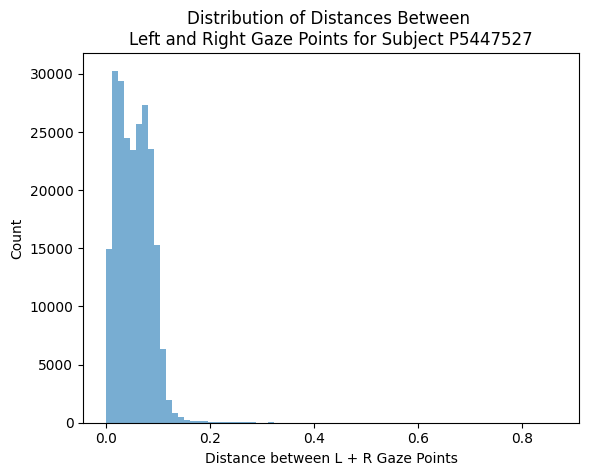

In [62]:
# run for just one subject
gaze_point_histogram(2, None)
plt.show()

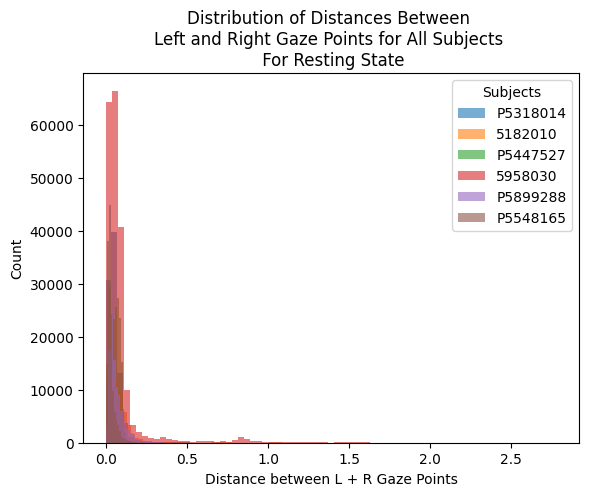

In [ ]:
fig, ax1 = plt.subplots()
results1 = []

for i in range(len(sub_files)):
    sub_name, dmax, nsamp, srate, over02, _ = gaze_point_histogram(i, ax=ax1)  # Pass shared axes
    results1.append({'input': i, 'sub_id': sub_name, 'dmax': dmax, 'nsamp': nsamp, 'srate': srate, 'over02': over02})

ax1.legend(title = 'Subjects')
ax1.set_title('Distribution of Distances Between \nLeft and Right Gaze Points for All Subjects \n For Resting State')
plt.show()

In [ ]:
pprint(results1, width = 200, sort_dicts = False)

[{'input': 0, 'sub_id': 'P5318014', 'dmax': 2.601616, 'nsamp': 170396, 'srate': 119.9959, 'over02': 1.6},
 {'input': 1, 'sub_id': '5182010', 'dmax': 1.939446, 'nsamp': 137769, 'srate': 119.9958, 'over02': 6.93},
 {'input': 2, 'sub_id': 'P5447527', 'dmax': 0.86599404, 'nsamp': 300111, 'srate': 119.9959, 'over02': 0.3},
 {'input': 3, 'sub_id': '5958030', 'dmax': 2.7787168, 'nsamp': 273627, 'srate': 119.9957, 'over02': 7.08},
 {'input': 4, 'sub_id': 'P5899288', 'dmax': 1.1290684, 'nsamp': 292138, 'srate': 119.9957, 'over02': 1.92},
 {'input': 5, 'sub_id': 'P5548165', 'dmax': 0.7700742, 'nsamp': 187767, 'srate': 119.996, 'over02': 0.12}]
